In [3]:
from detection_and_metrics import fit_cls_model
from numpy import load, int64
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import argmax, from_numpy
from detection_and_metrics import fit_cls_model
from numpy import load, int64
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import argmax, from_numpy

import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import numpy as np
import tqdm
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils



data = load('./tests/00_unittest_classifier_input/train_data.npz')
X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
#X_train, X_test = from_numpy(X_train), from_numpy(X_test)
#y_train, y_test = from_numpy(y_train), from_numpy(y_test)
#cls_model = fit_cls_model(X_train, y_train)
#y_predicted = argmax(cls_model(X_test), dim = 1)
#assert accuracy_score(y_test, y_predicted) > 0.9


In [2]:
import matplotlib.pyplot as plt

# Функция для отображения первых n изображений и их меток
def display_images_with_labels(X, y, n=5):
    # Проверяем, что n не превышает размер набора данных
    n = min(n, len(X))
    
    # Создаем графики для первых n изображений
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[i][0], cmap='gray')  # берем первое (и единственное) измерение канала
        print(X[i][0])
        plt.title(f'Label: {y[i]}')
        plt.axis('off')  
    
    plt.tight_layout()
    plt.show()

In [3]:
from detection_and_metrics import fit_cls_model
from numpy import load, int64
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import argmax, from_numpy
from detection_and_metrics import fit_cls_model
from numpy import load, int64
from os.path import dirname, join
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import argmax, from_numpy

import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import numpy as np
import tqdm
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import copy

LR = 1e-4
OUTPUT_SIZE = 2
BATCH_SIZE = 32
MAX_EPOCHS = 20
NUM_WORKERS = 0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cuda:0"):
    torch.set_float32_matmul_precision('medium')

augmentations = [
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=(-0.1, 0.2), p=0.25),
    A.GaussianBlur(sigma_limit=(0.2, 1), p=0.4),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(var_limit=(0.01, 0.02), p=0.3),
]

common_transforms = [
    A.Normalize(max_pixel_value=1.0),
    A.pytorch.transforms.ToTensorV2(),
]

MyFitTransform = A.ReplayCompose(augmentations + common_transforms)
MyPredictTransform = A.ReplayCompose(common_transforms)

In [4]:
class CarDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        assert self.X.shape[0] == self.y.shape[0] 

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.X[idx][0]
        label = self.y[idx]
        

        if self.transform:
            augmented = self.transform(image=image)
            #print(augmented['replay'])
            image = augmented['image'][0]
        #sample = {'image': image, 'label': label}
        return image, label

In [5]:
ds_train = CarDataset(X_train, y_train, MyFitTransform)
ds_valid = CarDataset(X_test, y_test, None)

dl_train = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)
dl_valid = DataLoader(
    ds_valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
)


torch.Size([40, 100])
tensor(2.2489) tensor(-1.9809)
tensor(1.) tensor(0.)


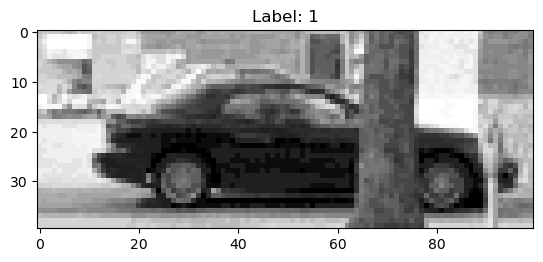

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.1179)
tensor(1.) tensor(0.)


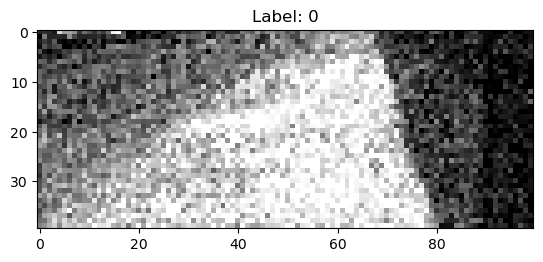

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.0568)
tensor(1.) tensor(0.)


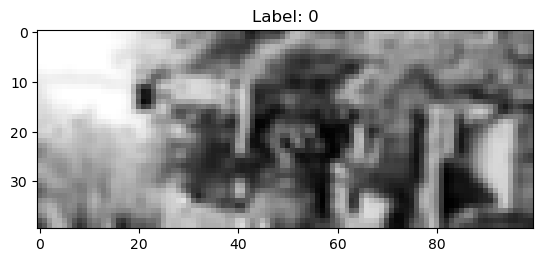

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.1179)
tensor(1.) tensor(0.)


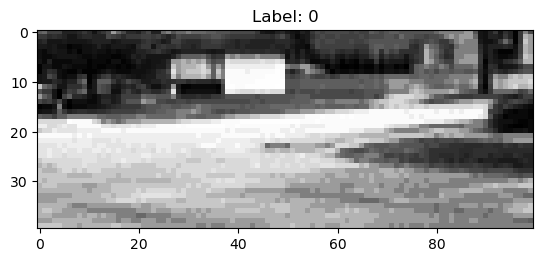

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2318) tensor(-2.1008)
tensor(1.) tensor(0.)


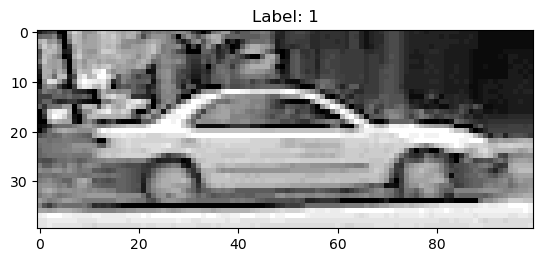

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.0665)
tensor(1.) tensor(0.)


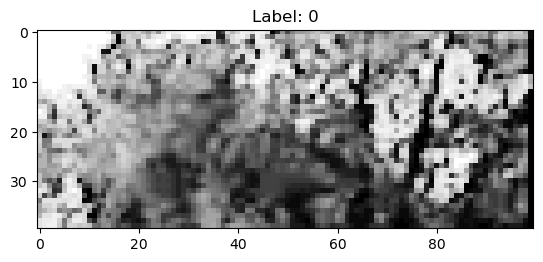

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.1179)
tensor(1.) tensor(0.)


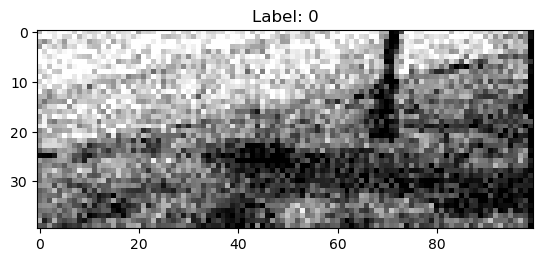

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.1179)
tensor(1.) tensor(0.)


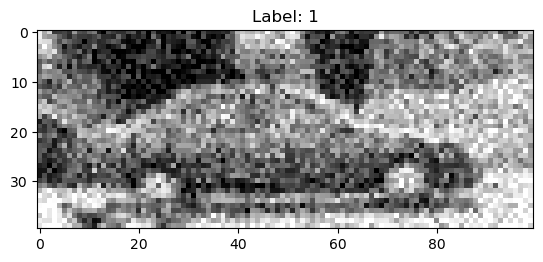

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.0492)
tensor(1.) tensor(0.)


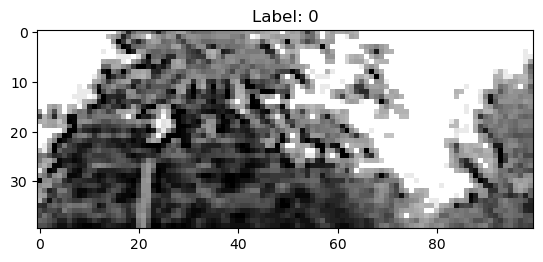

<Figure size 600x600 with 0 Axes>

torch.Size([40, 100])
tensor(2.2489) tensor(-2.1179)
tensor(1.) tensor(0.)


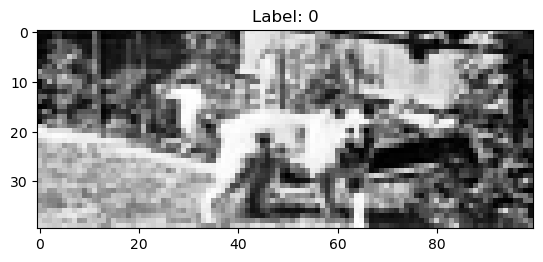

<Figure size 600x600 with 0 Axes>

In [6]:
for i in range(10):
    image, label = ds_train[i]
    
    print(image.shape)
    print(image.max(), image.min())
    image = (image - image.min()) / (image.max() - image.min())
    print(image.max(), image.min())
    plt.imshow(image, cmap='gray')  # берем первое (и единственное) измерение канала
    plt.title(f'Label: {label}')
    plt.figure(figsize=(6, 6))
    plt.show()
    

In [7]:
class MyModel(nn.Sequential):
    def __init__(self):
        super().__init__()
        
        def convpool(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels//2, 3, stride=1, padding=1),
                nn.LeakyReLU(0.3),
                nn.Conv2d(out_channels//2, out_channels, 3, stride=1, padding=1),
                nn.LeakyReLU(0.3),
                nn.Dropout(0.2),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            )

        self.convpool1 = convpool(1, 32)
        self.convpool2 = convpool(32, 128)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 10 * 25, 256),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(256, OUTPUT_SIZE)
        )
        
model = MyModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [8]:
import torch
import torch.nn as nn
testModel1 = nn.Conv2d(2, 8, (3, 4), stride=1, padding=1)
testModel2 = nn.Linear(2 * 3 * 4, 8)

In [9]:
print(testModel1.weight.data.shape)
print(testModel2.weight.data.shape)

torch.Size([8, 2, 3, 4])
torch.Size([8, 24])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import numpy as np
import tqdm
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.metrics import accuracy_score
import copy

LR = 5e-4
OUTPUT_SIZE = 2
BATCH_SIZE = 32
MAX_EPOCHS = 10
NUM_WORKERS = 6
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if DEVICE == torch.device("cuda:0"):
    torch.set_float32_matmul_precision('medium')

augmentations = [
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=(-0.1, 0.2), p=0.25),
    A.GaussianBlur(sigma_limit=(0.2, 1), p=0.4),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(var_limit=(0.01, 0.02), p=0.3),
]

common_transforms = [
    A.Normalize(max_pixel_value=1.0),
    A.pytorch.transforms.ToTensorV2(),
]

MyFitTransform = A.ReplayCompose(augmentations + common_transforms)
MyPredictTransform = A.ReplayCompose(common_transforms)

def ensure_numpy(image):
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    elif not isinstance(image, np.ndarray):
        raise TypeError
    return image

class CarDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        assert self.X.shape[0] == self.y.shape[0] 

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.X[idx][0]
        label = self.y[idx]
        

        if self.transform:
            image = ensure_numpy(image)
            augmented = self.transform(image=image)
            #print(augmented['replay'])
            image = augmented['image'][0]
        #sample = {'image': image, 'label': label}
        
        return image.unsqueeze(0), label

class MyModel1(nn.Module):
    def __init__(self):
        super().__init__()
        
        def convpool(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels//2, 3, stride=1, padding=1),
                nn.LeakyReLU(0.3),
                nn.Conv2d(out_channels//2, out_channels, 3, stride=1, padding=1),
                nn.LeakyReLU(0.3),
                nn.Dropout(0.2),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            )

        self.model = nn.Sequential(
            convpool(1, 32),
            convpool(32, 128),
            nn.Flatten(),
            nn.Linear(128 * 10 * 25, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, OUTPUT_SIZE)
        )
    def forward(self, X):
        #X = X.unsqueeze(1)
        return self.model(X)

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.LeakyReLU(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.LeakyReLU(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.LeakyReLU(0.3),
            nn.MaxPool2d(kernel_size=(2, 5), stride=(1, 1)),
            
            nn.Flatten(),
            nn.Linear(128 * 9 * 21, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, OUTPUT_SIZE)
        )
    def forward(self, X):
        #X = X.unsqueeze(1)
        return self.model(X)

class ModifiedModel(MyModel):
    def __init__(self):
        super(ModifiedModel, self).__init__()

    def forward(self, X):
        return self.model(X)[:, 1, ...]

def get_cls_model(input_shape=(1, 40, 100)):
    """
    :param input_shape: tuple (n_rows, n_cols, n_channels)
            input shape of image for classification
    :return: nn model for classification
    """
    # your code here \/
    classification_model = MyModel()
    return classification_model
    # your code here /\


def fit_cls_model_good(X, y, Xv, yv):
    """
    :param X: 4-dim tensor with training images
    :param y: 1-dim tensor with labels for training
    :return: trained nn model
    """
    # your code here \/
    model = get_cls_model()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    #ds_train = CarDataset(X, y, MyFitTransform)
    ds_train = CarDataset(X, y, None)
    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
    )

    ds_valid = CarDataset(Xv, yv, None)
    dl_valid = DataLoader(
        ds_valid,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=NUM_WORKERS,
    )
    
    

    epochs = 100
    max_acc = float('-inf')
    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        progress_bar = tqdm.tqdm(dl_train, desc=f'Epoch [{epoch + 1}/{epochs}]')
        for inputs, labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': running_loss / (progress_bar.n + 1)})

        model.eval()
        outputs = model(Xv)
        val_loss = loss_fn(outputs, yv)
        scheduler.step(val_loss)

        y_predicted = torch.argmax(outputs, 1)
        acc = accuracy_score(yv, y_predicted)
        print('Accuracy of the model on the validation set: {}%'.format(100 * acc))
        #if acc > max_acc:
            #torch.save(model.state_dict(), 'classifier_model_SOTA.pt')
    #torch.save(model.state_dict(), 'classifier_model.pt')
    return model

def fit_cls_model(X, y, fast_train=True):
    """
    :param X: 4-dim tensor with training images
    :param y: 1-dim tensor with labels for training
    :return: trained nn model
    """
    # your code here \/
    model = get_cls_model()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    #ds_train = CarDataset(X, y, MyFitTransform)
    ds_train = CarDataset(X, y, None)
    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=NUM_WORKERS,
    )
    
    model.train()
    if fast_train:
        epochs = 4
    else:
        epochs = MAX_EPOCHS
    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm.tqdm(dl_train, desc=f'Epoch [{epoch + 1}/{epochs}]')
        for inputs, labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': running_loss / (progress_bar.n + 1)})

    model.eval()
    if not fast_train:
        outputs = model(X)
        y_predicted = torch.argmax(outputs, 1)
        print('Accuracy of the model on the test set: {}%'.format(100 * accuracy_score(y, y_predicted)))

    return model
    # your code here /\




# ============================ 2 Classifier -> FCN =============================
def get_detection_model(cls_model):
    """
    :param cls_model: trained cls model
    :return: fully convolutional nn model with weights initialized from cls
             model
    """
    # your code here \/
    fc_weights = cls_model.model[10].weight.data # (128 * 5 * 5, 256) = (256, 3840) -> (256, 128, 5, 5)
    conv_layer_flatten_lin = nn.Conv2d(128, 256, kernel_size=(9, 21), stride=(1, 1), padding=(0, 0))
    conv_layer_flatten_lin.weight.data = fc_weights.view(256, 128, 9, 21)

    fc_weights = cls_model.model[13].weight.data # (256, 2) = (2, 256) -> (2, 256, 1, 1)
    conv_layer_lin = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
    conv_layer_lin.weight.data = fc_weights.view(2, 256, 1, 1)

    detection_model = ModifiedModel()
    detection_model.load_state_dict(cls_model.state_dict())
    detection_model.model[9] = conv_layer_flatten_lin
    detection_model.model[10] = detection_model.model[11]
    detection_model.model[11] = detection_model.model[12]
    detection_model.model[12] = conv_layer_lin
    detection_model.model[13] = nn.Softmax(dim=1)
    #detection_model.model = nn.Sequential(*[layer for layer in detection_model.model if layer is not None])
    return detection_model
    # your code here /\

In [6]:
data = load('./tests/00_unittest_classifier_input/train_data.npz')
X = data['X'].reshape(-1, 1, 40, 100)   #pytorch dimensions are (N, C, H, W)
y = data['y'].astype(int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train, X_test = from_numpy(X_train), from_numpy(X_test)
y_train, y_test = from_numpy(y_train), from_numpy(y_test)
cls_model = fit_cls_model(X_train, y_train, fast_train=True)

outputs = cls_model(X_test)
y_predicted = torch.argmax(outputs, 1)
print('Accuracy of the model on the test set: {}%'.format(100 * accuracy_score(y_test, y_predicted)))

Epoch [4/4]: 100%|█████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.22it/s, Loss=0.0198]


Accuracy of the model on the test set: 98.09885931558935%


In [12]:
display(cls_model)

MyModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): LeakyReLU(negative_slope=0.3)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (4): LeakyReLU(negative_slope=0.3)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (7): LeakyReLU(negative_slope=0.3)
    (8): MaxPool2d(kernel_size=(2, 5), stride=(2, 5), padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=3200, out_features=256, bias=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [18]:
import copy
detection_model = get_detection_model(cls_model)
display(detection_model)
display(X_train.shape)
outputs = detection_model(X_train)
y_predicted = (outputs > 0.50).int().squeeze()
print('Accuracy of the model on the test set: {}%'.format(100 * accuracy_score(y_train, y_predicted.squeeze())))

ModifiedModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): LeakyReLU(negative_slope=0.3)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (4): LeakyReLU(negative_slope=0.3)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (7): LeakyReLU(negative_slope=0.3)
    (8): MaxPool2d(kernel_size=(2, 5), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(9, 21), stride=(1, 1))
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
    (13): Softmax(dim=1)
  )
)

torch.Size([787, 1, 40, 100])

Accuracy of the model on the test set: 98.34815756035579%


In [10]:
outputs.shape

torch.Size([787, 1, 1])

In [19]:
from common import read_for_detection
test_dir = 'tests/03_unittest_detector_input'
img_dir = join(test_dir, 'test_imgs')
gt_path = join(test_dir, 'true_detections.json')
data = read_for_detection(img_dir, gt_path)

In [20]:
image = np.random.rand(1, 1, 43, 100).astype(np.float32)
#image = np.random.rand(1, 1, 48, 120).astype(np.float32)
image = from_numpy(image)
print(image.shape)
with torch.no_grad():
    logits = detection_model(image)
logits.shape

torch.Size([1, 1, 43, 100])


torch.Size([1, 1, 1])

In [21]:
image, bboxes = data['test-11.png']
print(image.shape)
print(bboxes)
#image = image[:46, :102] 
#image = X_train[0].numpy()


(150, 200)
[[38, -5, 40, 100], [40, 100, 40, 100]]


In [22]:
from matplotlib import patches
def get_bboxes_from_mask(mask, dh=4, dw=4):
    # Находим индексы ненулевых элементов в маске
    non_zero_indices = np.argwhere(mask.numpy() > 0)
    
    # Список для хранения bbox'ов
    bboxes = []

    for idx in non_zero_indices:
        y, x = idx 
        # Составляем bbox: [x, y, 40, 100]
        bbox = [y * dh, x * dw, 40, 100]  # Применяем умножение на dh и dw
        bboxes.append(bbox)
    
    return bboxes

# Пример использования:
def show_image_and_heatmap(image, bboxes_gt, threshold=0.5):
    dh = 4
    dw = 4
    
    with torch.no_grad():
        logits = detection_model(from_numpy(image).unsqueeze(0).unsqueeze(0))
    
    logits = logits.detach().cpu()
    mask = (logits > threshold).int().squeeze()
    logits = logits.squeeze().numpy()
    
    # Получаем bounding box'ы
    bboxes = get_bboxes_from_mask(mask, dh, dw)
    
    print(f"Bounding boxes: {bboxes}")
    
    # Отображение изображения и heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Gray Image')
    

    for bbox in bboxes_gt:
        y, x, h, w = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='g', facecolor='none')
        ax1.add_patch(rect)

    for bbox in bboxes:
        y, x, h, w = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
    
    ax1.axis('off')

    heatmap = ax2.imshow(logits, cmap='hot', interpolation='nearest')
    ax2.set_title('Heatmap from Tensor')
    ax2.axis('off')
    
    fig.colorbar(heatmap, ax=ax2)
    
    plt.show()

Bounding boxes: [[24, 56, 40, 100], [32, 0, 40, 100], [32, 4, 40, 100], [36, 0, 40, 100], [36, 4, 40, 100], [36, 8, 40, 100], [36, 12, 40, 100], [36, 40, 40, 100], [36, 44, 40, 100], [36, 48, 40, 100], [36, 52, 40, 100], [36, 56, 40, 100], [36, 84, 40, 100], [36, 88, 40, 100], [36, 92, 40, 100], [36, 96, 40, 100], [36, 100, 40, 100], [40, 0, 40, 100], [40, 4, 40, 100], [40, 8, 40, 100], [40, 32, 40, 100], [40, 36, 40, 100], [40, 40, 40, 100], [40, 44, 40, 100], [40, 48, 40, 100], [40, 52, 40, 100], [40, 56, 40, 100], [40, 60, 40, 100], [40, 76, 40, 100], [40, 80, 40, 100], [40, 84, 40, 100], [40, 88, 40, 100], [40, 92, 40, 100], [40, 96, 40, 100], [40, 100, 40, 100], [44, 88, 40, 100], [44, 92, 40, 100], [44, 96, 40, 100], [44, 100, 40, 100]]


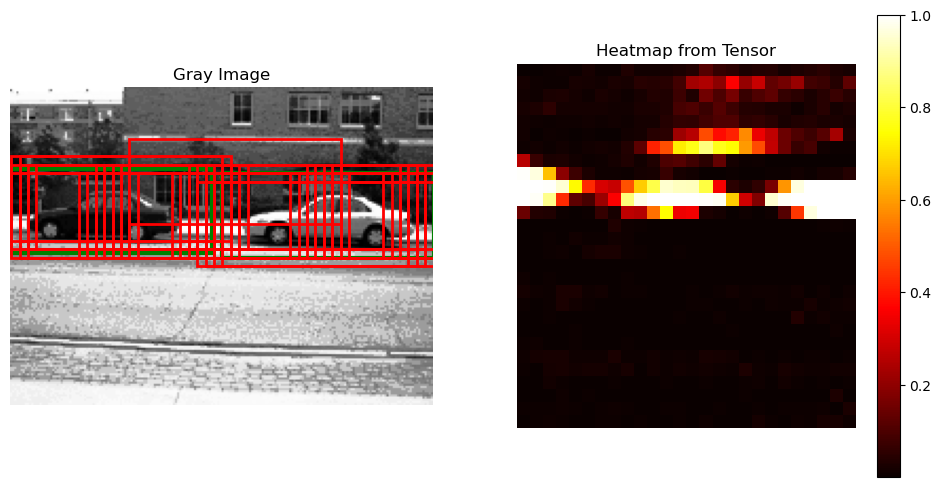

In [23]:
show_image_and_heatmap(image, bboxes, 0.8)

In [22]:
def calc_iou(first_bbox, second_bbox):
    """
    :param first bbox: bbox in format (row, col, n_rows, n_cols)
    :param second_bbox: bbox in format (row, col, n_rows, n_cols)
    :return: iou measure for two given bboxes
    """
    # your code here \/
    row1, col1, n_rows1, n_cols1 = first_bbox
    row2, col2, n_rows2, n_cols2 = second_bbox
    
    x_start = max(col1, col2)
    y_start = max(row1, row2)
    x_end = min(col1 + n_cols1, col2 + n_cols2)
    y_end = min(row1 + n_rows1, row2 + n_rows2)
    
    if x_start < x_end and y_start < y_end:
        A = (x_end - x_start) * (y_end - y_start)
    else:
        A = 0
    
    B = n_cols1 * n_rows1 + n_cols2 * n_rows2 - A

    return A / B
    # your code here /\

from collections import defaultdict
def calc_auc(pred_bboxes, gt_bboxes):
    """
    :param pred_bboxes: dict of bboxes in format {filename: detections}
        detections is a N x 5 array, where N is number of detections. Each
        detection is described using 5 numbers: [row, col, n_rows, n_cols,
        confidence].
    :param gt_bboxes: dict of bboxes in format {filenames: bboxes}. bboxes is a
        list of tuples in format (row, col, n_rows, n_cols)
    :return: auc measure for given detections and gt
    """
    # your code here \/
    iou_thr = 0.5
    assert pred_bboxes.keys() == gt_bboxes.keys()

    all_tp = []
    all_fp = []
    fn = 0
    for img_name in pred_bboxes.keys():
        tp = []
        fp = []
        pred_bbx = pred_bboxes[img_name]
        gt_bbx = gt_bboxes[img_name]
        sorted_bboxes = sorted(pred_bbx, key=lambda x: x[-1], reverse=True)

        for pred in sorted_bboxes:
            iou_max = 0
            gt_best = []
            for gt in gt_bbx:
                iou = calc_iou(gt, pred[0:4])
                if iou > iou_max:
                    iou_max = iou
                    gt_best = gt

            if iou_max > iou_thr:
                tp.append(pred)
                gt_bbx.remove(gt_best)
            else:
                fp.append(pred)

        fn += len(gt_bbx)
        all_tp += tp
        all_fp += fp
    #print(all_tp)
    #print(all_fp)
    #print(fn)
    list1 = sorted(all_tp + all_fp, key=lambda x: x[-1], reverse=True)
    list2 = sorted(all_tp, key=lambda x: x[-1], reverse=True)
    dict_p = defaultdict(int)
    dict_tp = defaultdict(int)
    for p in list1:
        dict_p[p[-1]] += 1
    for tp in list2:
        dict_tp[tp[-1]] += 1
    #print(dict_tp)
    #print(dict_p)
    
    precrec = []
    precrec.append((0, 1))
    cum_tp, cum_p = 0, 0
    for c in dict_p.keys():
        cum_p += dict_p[c]
        if c in dict_tp:
            cum_tp +=  dict_tp[c]
        c_recall = cum_tp / (len(all_tp) + fn)
        c_precision = cum_tp / cum_p
        dot = (c_recall, c_precision)
        precrec.append(dot)
    #print(precrec)
    auc_pr = 0
    for i in range(1, len(precrec)):
        delta = precrec[i][0] - precrec[i - 1][0]
        auc_pr += 0.5 * delta * (precrec[i][1] + precrec[i - 1][1]) 
    
    #print(auc_pr)
    return auc_pr
    # your code here /\



In [23]:
pred_bbox = {"img1": [[8, 112, 40, 100, 0.4083907],
                        [56, 108, 40, 100, 0.40634221],
                        [4, 20, 40, 100, 0.40198728],
                        [68, 24, 40, 100, 0.4007026],
                        [64, 160, 40, 100, 0.42576572],
                        [16, 12, 40, 100, 0.4111293],
                        [12, 16, 40, 100, 0.42142084],
                        [60, 36, 40, 100, 0.41478667]]}
true_bbox = {"img1": [[69, 68, 40, 100],
                      [62, 31, 40, 100],
                      [61, 137, 40, 100]]}
calc_auc(pred_bbox, true_bbox)

[[64, 160, 40, 100, 0.42576572], [60, 36, 40, 100, 0.41478667]]


0.5277777777777777

In [ ]:
pred_bbox = {"img1": [[8, 112, 40, 100, 0.4083907],
                        [56, 108, 40, 100, 0.40634221],
                        [4, 20, 40, 100, 0.40198728],
                        [68, 24, 40, 100, 0.4007026],
                        [64, 160, 40, 100, 0.42576572],
                        [16, 12, 40, 100, 0.4111293],
                        [12, 16, 40, 100, 0.42142084],
                        [60, 36, 40, 100, 0.41478667]]}
true_bbox = {"img1": [[69, 68, 40, 100],
                      [62, 31, 40, 100],
                      [61, 137, 40, 100]]}

show_bbox(pred_bbox["img1"], true_bbox["img1"])

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_bbox(bboxes, bboxes_gt):
    fig, ax = plt.subplots()  # Создаем фигуру и оси
    ax.set_xlim(0, 260)
    ax.set_ylim(0, 125)
    for bbox in bboxes_gt:
        y, x, h, w = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for bbox in bboxes:
        y, x, h, w, t = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f'{t}', color='r', fontsize=12, fontweight='bold', ha='left', va='bottom')
    plt.show()

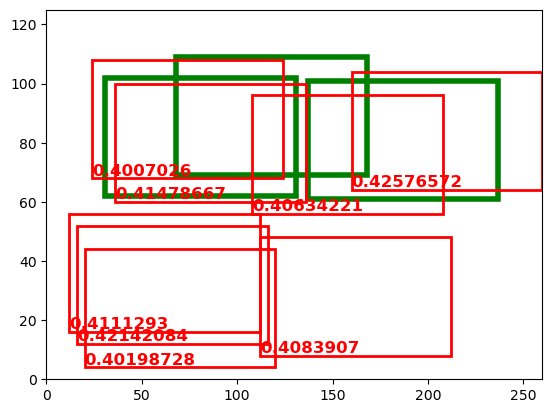

In [37]:
pred_bbox = {"img1": [[8, 112, 40, 100, 0.4083907],
                        [56, 108, 40, 100, 0.40634221],
                        [4, 20, 40, 100, 0.40198728],
                        [68, 24, 40, 100, 0.4007026],
                        [64, 160, 40, 100, 0.42576572],
                        [16, 12, 40, 100, 0.4111293],
                        [12, 16, 40, 100, 0.42142084],
                        [60, 36, 40, 100, 0.41478667]]}
true_bbox = {"img1": [[69, 68, 40, 100],
                      [62, 31, 40, 100],
                      [61, 137, 40, 100]]}
show_bbox(pred_bbox["img1"], true_bbox["img1"])

In [31]:
a = np.array([1, 2, 3])
a

array([1, 2, 3])

In [26]:
a.shape

(3,)

In [32]:
a = a.reshape(-1, 1)

In [33]:
a.shape

(3, 1)